In [205]:
import pymust, numpy as np, matplotlib.pyplot as plt

# Practice 6: Pulse wave Doppler

Here we will work with a single-element probe, to understand the pulse wave Doppler. In this modality, instead of just looking at the phase-shift of the different recieved signals, we will focus on assessing how the sample recieved at a specific time after emmision (i.e., changes in the multiple recieved signals. Remember that, if we are emmiting a pure sinusoid, the recieved signal from a scatterer moving at velocity $v$ will be:
$$r_i(t) = sin(2\pi f_c t + i \Delta^v_\theta)$$
Where $\Delta^v_\theta$ is the phase shift discussed in the previous practice, which depends on the probe velocity, the PRF and the central frequency. If, instead a single scatterer we have several at that distance of the transducer,each moving at different velocity towards/away from the probe, then we will obtain a signal of the form, where $RC_k$ refers to the reflective coefficient of the k-th scatterer:
$$r_i(t) = \sum_k^N RC_k sin(2\pi f_c t + i \Delta^{vk}_\theta)$$

Then, since we are only interested in a specific timepoint(let's call it $t'$), we can obtain the different samples
$$
(r_0(t'), r_1(t'), r_2(t'), ... r_N(t'))
$$
This signal, corresponds to a combinations of sinus on $i$, each variying with "frequency" $ \Delta^{vk}_\theta$. Therefore, by using the Fourier transform, we can obtain the different phase shifts of each scatterers, each of them corresponds to a certain velocity. This is the basis of the spectral Doppler. Notice that since we are using Fourier Transform, we will only be able to evaluate velocities at specific bins, and we will need more repeated pulses to accurately reconstruct the spectogramm, when compared to color Doppler where only the "mean" phase shift is recovered.

Note: in a real system, instead of focusing in a singular time-sample, we would focus in a range using a window-filtering.

***Exercise 1: several scatterers***
1. Use color Doppler (function pymust.iq2doppler, you do not need to geenerate the images) two scatterers at the same point, moving in opposite sense along the z-axis. What is the recovered velocity, using color Doppler, and why?
1. Plot the polar angles (angle of the complex number), and the real and complex parts of the IQ signal; for the following combinations of velocities of the two scatterers [(-1e-2,1e-2), (1e-2, 1e-2),  (1e-1, 1e-1), (3e-1,1e-1)]. Comment on what you see.
1. Before, the two scatters have the same reflexive coefficient. Repeat the previous exercise with the 2nd scatterer having the double reflexive coefficient (RC) than the first one.

***Exercise 2: Spectogramm***
1. With the scatterers moving at 5e-2, and -5e-2 respectively, use spectral Doppler with 32 firings; and compute the spectogramm. What can you see know?
1. Reduce the number of acquisitions to 16, and increase it to 64. Comment on the differences on the spectra of the previous exercise.
1. Compute the spectogramm for all the combinations of scatterers in exercise 1.2; Comment what you see.
1. Redo the previous exercise, with the second scatterer having more RC.

In [215]:
class SimulationWithMovement:
    """
    This class allows to do a simulation with scatterers moving with a certain velocity
    """
    def __init__(self, param, xScatterers, zScatterers, vXScatterers, vZScatterers, RCScatterers):
        self.param = param
        self.xScatterers_ = xScatterers.copy()
        self.zScatterers_ = zScatterers.copy()
        self.vXScatterers = vXScatterers.copy()
        self.vZScatterers = vZScatterers.copy()
        self.RCScatterers = RCScatterers.copy()
        self.reset()
        
    def simulate(self, nReps):
        assert self.param.PRF is not None, 'param has not the PRF set. You should set it manually before calling this function.'
            
        zScatterers = self.zScatterers.copy()
        xScatterers = self.xScatterers.copy()

        for i in range(nReps):
            txdelay = pymust.txdelay(0, 5e-2, self.param)
            RF_new, _ = pymust.simus(xScatterers, zScatterers, self.RCScatterers,  txdelay, self.param)
            xScatterers += self.vXScatterers /self.param.PRF
            zScatterers += self.vZScatterers /self.param.PRF
            if i ==0:
                RFs = np.zeros([RF_new.shape[0], RF_new.shape[1], nReps])

            RFs[:, :, i] = RF_new
        return RFs
    def reset(self):
        self.xScatterers = self.xScatterers_.copy()
        self.zScatterers = self.zScatterers_.copy()


In [216]:
param = pymust.getparam('P4-2v')
param.Nelements = 1
param.TXnow = 10

In [233]:
#Need to introduce a second scatterer so that the recieved signal has a constant length. 
#You can ignore it, since it has RC = 0
xScatterers= np.array([0,0, 0], dtype = float)
zScatterers = np.array([5e-2, 5e-2, 6e-2]) 
vZScatterers = np.array([-32e-2, -32e-2, 0])
vXScatterers = np.zeros(3, dtype = float)
RCScatterers = np.array([1, 1, 0])

param.PRF = 1000 #PRF = 1lHz

nReps = 16

s = SimulationWithMovement(param, xScatterers, zScatterers, vXScatterers, vZScatterers, RCScatterers)
RFs = s.simulate(nReps)
ts = np.arange(RFs.shape[0])/param.fs

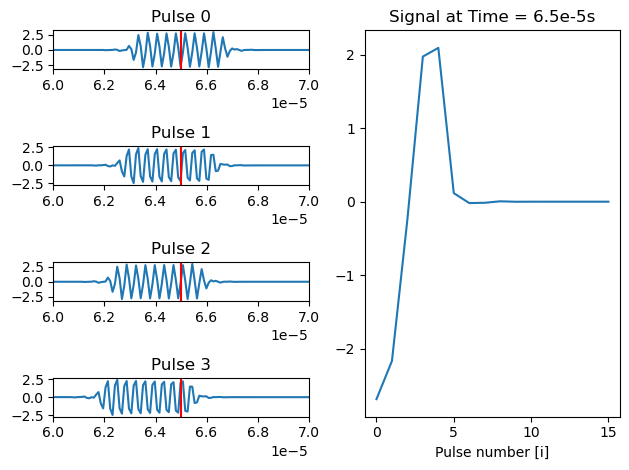

In [234]:
# Visualisation for the figure, not necessary for the simulation
fig, fs = plt.subplots(nrows = 4, ncols = 2)
for i in range(4):
    plt.sca(fs[i, 0])
    plt.xlim(6e-5, 7e-5)
    plt.plot(ts, RFs[:,0,i])
    plt.axvline(6.5e-5, color = 'r')
    plt.title(f"Pulse {i}")
plt.tight_layout()

gs = fs[0, 1].get_gridspec()
# remove the underlying axes
for ax in fs[:, 1]:
    ax.remove()
axbig = fig.add_subplot(gs[:, -1])
idClosestToTime = np.argmin(np.abs(ts - 6.5e-5))
plt.title("Signal at Time = 6.5e-5s")
plt.plot(RFs[idClosestToTime, 0, :])
plt.xlabel('Pulse number [i]')
plt.tight_layout()

In [210]:
x = np.array([[0]])
z = np.array([[5e-2]])
IQs = np.stack([pymust.rf2iq(RFs[:,:,i], param) for i in range(RFs.shape[-1])], axis = 2)
Mdas = pymust.dasmtx(IQs[:,:,0],x,z, param)  #MDAS using a single pixels, to obtain the temporal samples in a certain range.
IQs_b = np.stack([ pymust.utils.applyDasMTX(Mdas, pymust.rf2iq(RFs[:,:,i], param),(1,1) )for i in range(RFs.shape[-1])], axis = 2)

/Users/gbernardino/miniconda3/envs/pymust/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Phase shift')

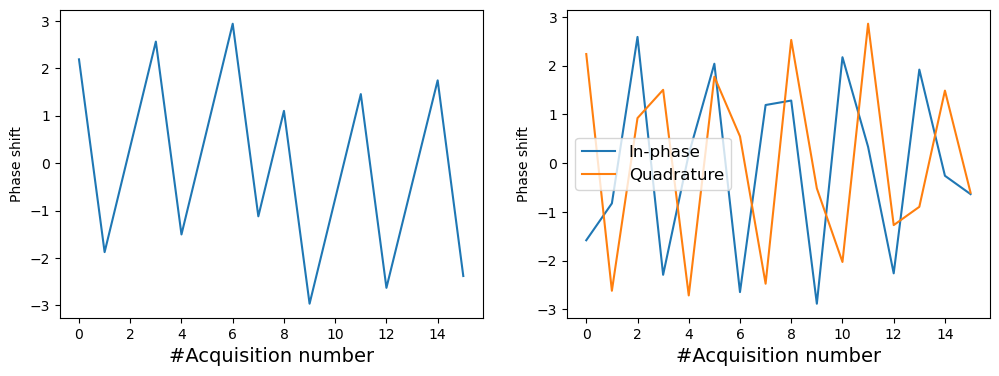

In [211]:
_, (f1, f2) = plt.subplots(ncols = 2, figsize = (12, 4))
plt.sca(f1)
plt.plot(np.angle(IQs_b).flatten())
plt.xlabel('#Acquisition number', fontsize = 14)
plt.ylabel('Phase shift')

plt.sca(f2)

plt.plot(IQs_b.flatten(), label = 'In-phase')
plt.plot(IQs_b.imag.flatten(), label = 'Quadrature')
plt.legend(fontsize = 12)
plt.xlabel('#Acquisition number', fontsize = 14)
plt.ylabel('Phase shift')


Text(0, 0.5, 'Sepctral Power [AU]')

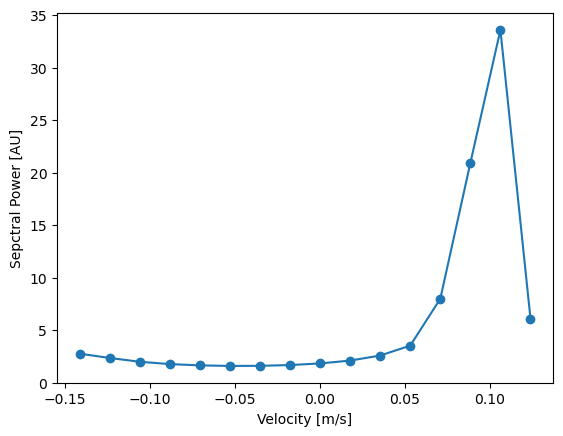

In [214]:
VN =  pymust.getNyquistVelocity(param)

freqs = np.fft.fftfreq(nReps)
freqs = freqs * VN/np.max(np.abs(freqs))
spectral_doppler = np.fft.fft(IQs_b).flatten()

idx = np.argsort(freqs)
freqs = freqs[idx]
spectral_doppler = spectral_doppler[idx]

plt.plot(freqs, np.abs(spectral_doppler), '-o')
#plt.axvline(-vZScatterers[0])
#plt.axvline(-vZScatterers[1])
plt.xlabel('Velocity [m/s]')
plt.ylabel('Sepctral Power [AU]')